In [249]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [201]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [202]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

0

### Visualization of the covariance matrix:

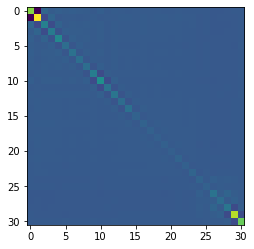

In [203]:
plt.imshow(syscov)


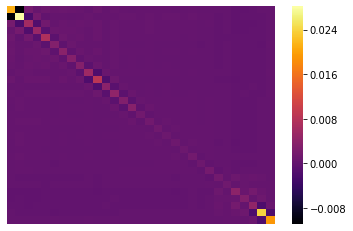

In [204]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
plt.savefig("original_cov_binned_JLA.png", dpi=200)

In [205]:
np.min(syscov), np.max(syscov) #checking non-negatives in the diagonal

(-0.01084098704, 0.02815552265)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [348]:
numMatrix = 1000
# noise_factor1 = 1e-4
noise_factor1 = 0.01
noise_factor2 = 0.1
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal(loc=0.0, scale=0.01, size=syscov.shape) 
    covset[i] = syscov  + noise_factor1 * err
    err = np.random.normal(loc=0.0, scale=0.01, size=syscov.shape) 
    covset_noise[i] = syscov  + noise_factor2 * err
#     fig = plt.figure(figsize=(6,6))
#     sns.heatmap(pd.DataFrame(pset[i]*maxval), 
#             fmt='g', xticklabels=False, yticklabels=False, 
#             cmap = 'inferno', cbar=False,
#             robust=False)
#     fig.savefig('image/covMatrix_{}.png'.format(i), dpi=300, )
#     plt.clf()

 Generating 1000 matrix 

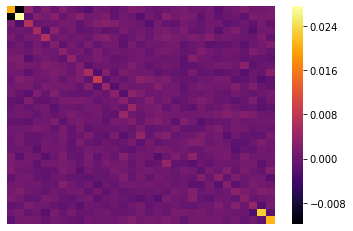

In [349]:
sns.heatmap(pd.DataFrame(covset_noise[1]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [350]:
print(np.shape(covset))

(1000, 31, 31)


(1000, 31, 31)


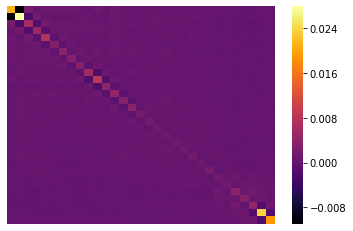

In [351]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [352]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(300, activation='tanh')(input_img)
x = layers.Dense(200, activation='tanh')(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)

#begin decoder
x = layers.Dense(200, activation='tanh')(encoded)
x = layers.Dense(300, activation='tanh')(x)
decoded = layers.Dense(31*31, activation='linear')(x)

# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 961)]             0         
_________________________________________________________________
dense_170 (Dense)            (None, 300)               288600    
_________________________________________________________________
dense_171 (Dense)            (None, 200)               60200     
_________________________________________________________________
dense_172 (Dense)            (None, 31)                6231      
_________________________________________________________________
dense_173 (Dense)            (None, 200)               6400      
_________________________________________________________________
dense_174 (Dense)            (None, 300)               60300     
_________________________________________________________________
dense_175 (Dense)            (None, 961)             

In [353]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-3]
decoder_layer2 = autoencoder.layers[-2]
decoder_layer3 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))

In [354]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=300,
                batch_size=16,
                shuffle=True,
                validation_data=(covset_noise_test, covset_test),
                callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/300
50/50 [==============================] - 1s 11ms/step - loss: 1.4065e-06 - val_loss: 4.2166e-07
Epoch 2/300
50/50 [==============================] - 0s 4ms/step - loss: 4.4261e-07 - val_loss: 4.2720e-07
Epoch 3/300
50/50 [==============================] - 0s 5ms/step - loss: 3.9288e-07 - val_loss: 3.4118e-07
Epoch 4/300
50/50 [==============================] - 0s 4ms/step - loss: 4.0100e-07 - val_loss: 4.3854e-07
Epoch 5/300
50/50 [==============================] - 0s 4ms/step - loss: 3.6714e-07 - val_loss: 3.1498e-07
Epoch 6/300
50/50 [==============================] - 0s 4ms/step - loss: 3.3969e-07 - val_loss: 3.5541e-07
Epoch 7/300
50/50 [==============================] - 0s 4ms/step - loss: 3.3067e-07 - val_loss: 2.8514e-07
Epoch 8/300
50/50 [==============================] - 0s 4ms/step - loss: 2.7093e-07 - val_loss: 2.5814e-07
Epoch 9/300
50/50 [==============================] - 0s 4ms/step - loss: 2.7474e-07 - val_loss: 2.4384e-07
Epoch 10/300
50/50 [================

Epoch 77/300
50/50 [==============================] - 0s 6ms/step - loss: 4.8095e-08 - val_loss: 5.7260e-08
Epoch 78/300
50/50 [==============================] - 0s 6ms/step - loss: 4.6145e-08 - val_loss: 6.7914e-08
Epoch 79/300
50/50 [==============================] - 0s 5ms/step - loss: 4.6597e-08 - val_loss: 6.1754e-08
Epoch 80/300
50/50 [==============================] - 0s 6ms/step - loss: 4.6059e-08 - val_loss: 5.3037e-08
Epoch 81/300
50/50 [==============================] - 0s 6ms/step - loss: 4.5463e-08 - val_loss: 5.6085e-08
Epoch 82/300
50/50 [==============================] - 0s 7ms/step - loss: 4.7328e-08 - val_loss: 5.6484e-08
Epoch 83/300
50/50 [==============================] - 0s 6ms/step - loss: 4.6037e-08 - val_loss: 5.9136e-08
Epoch 84/300
50/50 [==============================] - 0s 5ms/step - loss: 4.4356e-08 - val_loss: 5.0552e-08
Epoch 85/300
50/50 [==============================] - 0s 6ms/step - loss: 4.2837e-08 - val_loss: 5.8162e-08
Epoch 86/300
50/50 [========

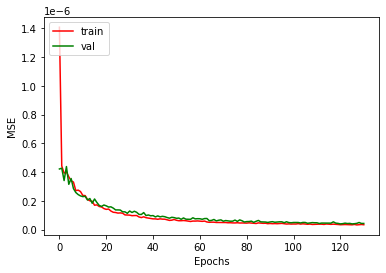

In [355]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLA.png', dpi=200)

In [356]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

4.012377274875689e-08 3.291995298582151e-08


In [357]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
np.min(encoded_imgs)

(200, 31)


-0.0010900665

(200, 961)


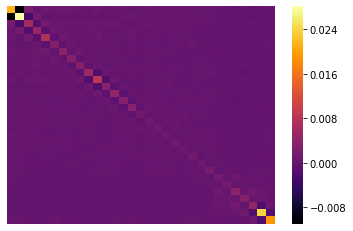

In [358]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")
# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


In [359]:
print(np.shape(decoded_imgs))

(200, 961)


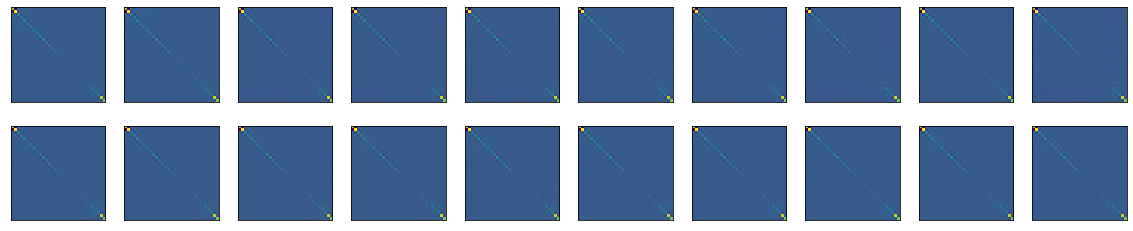

In [360]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(covset_test[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

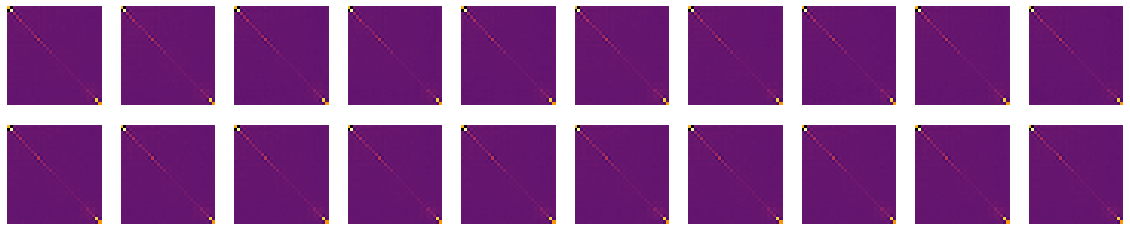

In [361]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we train another neural network for z and $D_L(z)$

           z      $D_L$
0   0.010000  32.953887
1   0.011762  33.879003
2   0.013833  33.842141
3   0.016270  34.118567
4   0.019136  34.593446
5   0.022507  34.939027
6   0.026472  35.252096
7   0.031135  35.748502
8   0.036620  36.069788
9   0.043071  36.434570
10  0.050658  36.651111
11  0.059582  37.158014
12  0.070077  37.430173
13  0.082422  37.956616
14  0.096941  38.253254
15  0.114018  38.612869
16  0.134102  39.067851
17  0.157725  39.341402
18  0.185509  39.792144
19  0.218188  40.156535
20  0.256623  40.564956
21  0.301829  40.905288
22  0.354997  41.421417
23  0.417532  41.790923
24  0.491083  42.231461
25  0.577590  42.617047
26  0.679335  43.052731
27  0.799004  43.504151
28  0.939753  43.972573
29  1.105296  44.514088
30  1.300000  44.821867


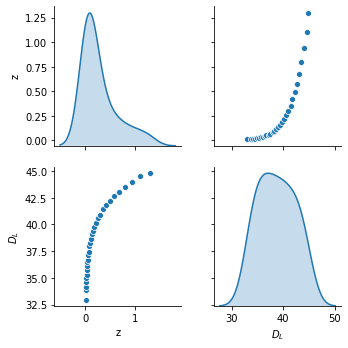

In [362]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
print(data.head(31))
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistbinnedJLA.png")

In [363]:
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
comp = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(comp)

data = data.values[shuffle]

In [364]:
z = data[:,0]
dl = data[:,1:]

In [365]:
# scalerz = StandardScaler()
# # scalerz = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scalerz.fit(z.reshape(-1,1))
# # apply transform
# z = scalerz.transform(z.reshape(-1,1))

In [366]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
dl_train, dl_test = np.split(dl, indx)

In [367]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.,
                                   patience=200,
                                   restore_best_weights=True)]

In [368]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(200, activation='relu')(efirst)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)

    elast = Dense(1, activation='linear')(x)
    return elast

batch_size = 1
epochs = 500
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_176 (Dense)            (None, 50)                100       
_________________________________________________________________
dense_177 (Dense)            (None, 200)               10200     
_________________________________________________________________
dense_178 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_179 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_180 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_181 (Dense)            (None, 200)             

In [369]:
model_train = neural_model.fit(z_train, dl_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, dl_test),
                                    callbacks=callbacks)

Epoch 1/500
24/24 [==============================] - 0s 6ms/step - loss: 1125.2114 - val_loss: 1060.7208
Epoch 2/500
24/24 [==============================] - 0s 2ms/step - loss: 254.9063 - val_loss: 744.3292
Epoch 3/500
24/24 [==============================] - 0s 2ms/step - loss: 353.8475 - val_loss: 346.6839
Epoch 4/500
24/24 [==============================] - 0s 2ms/step - loss: 185.5871 - val_loss: 219.3387
Epoch 5/500
24/24 [==============================] - 0s 2ms/step - loss: 25.6026 - val_loss: 76.4546
Epoch 6/500
24/24 [==============================] - 0s 2ms/step - loss: 19.7107 - val_loss: 46.1071
Epoch 7/500
24/24 [==============================] - 0s 2ms/step - loss: 10.4058 - val_loss: 20.0887
Epoch 8/500
24/24 [==============================] - 0s 2ms/step - loss: 5.2760 - val_loss: 33.9738
Epoch 9/500
24/24 [==============================] - 0s 2ms/step - loss: 7.8865 - val_loss: 23.2249
Epoch 10/500
24/24 [==============================] - 0s 2ms/step - loss: 4.5216 - 

24/24 [==============================] - 0s 2ms/step - loss: 0.9188 - val_loss: 0.8781
Epoch 83/500
24/24 [==============================] - 0s 2ms/step - loss: 1.3996 - val_loss: 1.3047
Epoch 84/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5934 - val_loss: 0.9128
Epoch 85/500
24/24 [==============================] - 0s 2ms/step - loss: 0.4043 - val_loss: 0.9130
Epoch 86/500
24/24 [==============================] - 0s 2ms/step - loss: 0.3205 - val_loss: 0.6180
Epoch 87/500
24/24 [==============================] - 0s 2ms/step - loss: 0.1823 - val_loss: 0.3341
Epoch 88/500
24/24 [==============================] - 0s 2ms/step - loss: 0.3482 - val_loss: 0.3212
Epoch 89/500
24/24 [==============================] - 0s 2ms/step - loss: 0.3574 - val_loss: 0.2375
Epoch 90/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5886 - val_loss: 0.8580
Epoch 91/500
24/24 [==============================] - 0s 2ms/step - loss: 0.7659 - val_loss: 1.8992
Epoch 92/500


24/24 [==============================] - 0s 2ms/step - loss: 0.7012 - val_loss: 0.2996
Epoch 164/500
24/24 [==============================] - 0s 2ms/step - loss: 0.2705 - val_loss: 0.2272
Epoch 165/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5239 - val_loss: 2.4223
Epoch 166/500
24/24 [==============================] - 0s 2ms/step - loss: 1.4358 - val_loss: 0.8949
Epoch 167/500
24/24 [==============================] - 0s 2ms/step - loss: 1.0012 - val_loss: 0.5423
Epoch 168/500
24/24 [==============================] - 0s 2ms/step - loss: 1.0581 - val_loss: 4.6499
Epoch 169/500
24/24 [==============================] - 0s 2ms/step - loss: 1.3517 - val_loss: 1.5216
Epoch 170/500
24/24 [==============================] - 0s 2ms/step - loss: 2.1065 - val_loss: 1.4100
Epoch 171/500
24/24 [==============================] - 0s 2ms/step - loss: 2.2841 - val_loss: 1.4231
Epoch 172/500
24/24 [==============================] - 0s 2ms/step - loss: 1.3123 - val_loss: 3.4617
Epoc

24/24 [==============================] - 0s 2ms/step - loss: 0.2434 - val_loss: 1.4490
Epoch 245/500
24/24 [==============================] - 0s 2ms/step - loss: 0.6860 - val_loss: 0.1124
Epoch 246/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5119 - val_loss: 0.4027
Epoch 247/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5515 - val_loss: 0.1606
Epoch 248/500
24/24 [==============================] - 0s 2ms/step - loss: 0.2457 - val_loss: 0.3616
Epoch 249/500
24/24 [==============================] - 0s 2ms/step - loss: 0.3742 - val_loss: 0.2159
Epoch 250/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5079 - val_loss: 0.3193
Epoch 251/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5986 - val_loss: 1.1041
Epoch 252/500
24/24 [==============================] - 0s 2ms/step - loss: 0.4448 - val_loss: 3.4337
Epoch 253/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5993 - val_loss: 0.9616
Epoc

24/24 [==============================] - 0s 2ms/step - loss: 0.6317 - val_loss: 1.8697
Epoch 326/500
24/24 [==============================] - 0s 2ms/step - loss: 1.3761 - val_loss: 1.9729
Epoch 327/500
24/24 [==============================] - 0s 2ms/step - loss: 2.3258 - val_loss: 0.0427
Epoch 328/500
24/24 [==============================] - 0s 2ms/step - loss: 0.6552 - val_loss: 1.1732
Epoch 329/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5694 - val_loss: 3.3620
Epoch 330/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5996 - val_loss: 0.3528
Epoch 331/500
24/24 [==============================] - 0s 2ms/step - loss: 0.3810 - val_loss: 0.1411
Epoch 332/500
24/24 [==============================] - 0s 2ms/step - loss: 0.2380 - val_loss: 0.0827
Epoch 333/500
24/24 [==============================] - 0s 2ms/step - loss: 0.4965 - val_loss: 2.2967
Epoch 334/500
24/24 [==============================] - 0s 2ms/step - loss: 0.7952 - val_loss: 2.5939
Epoc

24/24 [==============================] - 0s 2ms/step - loss: 0.2810 - val_loss: 0.9098
Epoch 407/500
24/24 [==============================] - 0s 2ms/step - loss: 0.3546 - val_loss: 0.0776
Epoch 408/500
24/24 [==============================] - 0s 2ms/step - loss: 0.6707 - val_loss: 0.0890
Epoch 409/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5035 - val_loss: 0.0989
Epoch 410/500
24/24 [==============================] - 0s 2ms/step - loss: 0.6752 - val_loss: 1.1112
Epoch 411/500
24/24 [==============================] - 0s 2ms/step - loss: 0.4313 - val_loss: 0.2793
Epoch 412/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5421 - val_loss: 0.3247
Epoch 413/500
24/24 [==============================] - 0s 2ms/step - loss: 0.3814 - val_loss: 0.3744
Epoch 414/500
24/24 [==============================] - 0s 2ms/step - loss: 0.5696 - val_loss: 5.2037
Epoch 415/500
24/24 [==============================] - 0s 2ms/step - loss: 0.9989 - val_loss: 0.0235
Epoc

24/24 [==============================] - 0s 2ms/step - loss: 2.6806 - val_loss: 1.8320


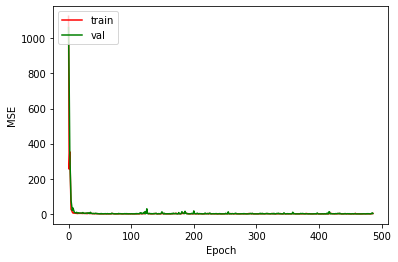

In [370]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_dlbinnedJla.png", dpi=200)

In [371]:
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])

(0.017644431442022324, 0.131439670920372)

In [372]:
pred = neural_model.predict(z_test)
pred

array([[39.91692 ],
       [40.586906],
       [41.51304 ],
       [42.477604],
       [43.02365 ],
       [43.78141 ],
       [44.854897]], dtype=float32)

In [373]:
# ranz = np.random.uniform(0, np.max(z), size=31)
ranz = np.linspace(np.min(z), np.max(z),31)

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model.predict(ranz)
pred_random

array([[35.170334],
       [37.72303 ],
       [39.071663],
       [39.47772 ],
       [39.88378 ],
       [40.2892  ],
       [40.694016],
       [41.098835],
       [41.503647],
       [41.90847 ],
       [42.28438 ],
       [42.454178],
       [42.57883 ],
       [42.703476],
       [42.828125],
       [42.952877],
       [43.07793 ],
       [43.202988],
       [43.328117],
       [43.453278],
       [43.57844 ],
       [43.70359 ],
       [43.82866 ],
       [43.95374 ],
       [44.082623],
       [44.21219 ],
       [44.341488],
       [44.470745],
       [44.599564],
       [44.72709 ],
       [44.854897]], dtype=float32)

In [374]:
# recover z
# z = scalerz.inverse_transform(z)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [375]:
fake_encoded = np.zeros((1, 31))

In [376]:
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))


(1, 31)
(31,)
(200, 31)


In [377]:
for i, avg in enumerate(avg_encoded):
    alpha = avg/z[i]
    fake_encoded[0, i] = alpha * ranz[i]

In [378]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake)

(1, 961)

In [379]:
decoded_fake[0, :]

array([ 2.11685412e-02, -1.10850995e-02,  1.65605335e-03, -2.58797896e-04,
        1.17883063e-03,  8.72849196e-05,  1.12516456e-03,  1.08141336e-03,
        5.14219515e-04,  6.96083764e-04,  1.32781966e-03,  7.13485642e-04,
        4.72328975e-05,  9.65457002e-04,  2.59423861e-04,  2.02022959e-04,
       -4.45412006e-05,  4.64388519e-04,  4.70044557e-04,  7.59688672e-04,
        1.75222696e-04,  1.63811375e-04, -1.81847718e-04, -5.59032196e-04,
        6.79553952e-04, -2.81493412e-05, -1.20269251e-05,  1.77447248e-04,
       -2.08777172e-04, -4.02414007e-05,  1.63785066e-04, -1.05923088e-02,
        2.82073673e-02, -2.37671495e-03,  1.17436680e-03, -5.94878220e-05,
        4.37142618e-04, -1.08917127e-04, -3.39267310e-04,  8.80024978e-04,
       -1.16203213e-04,  4.29529580e-04,  1.34171546e-03,  8.47301329e-04,
        1.23393862e-03,  1.16291712e-03,  7.22672557e-04,  7.91033555e-04,
        8.88800481e-04, -7.68250204e-04, -9.38649755e-05, -1.40787073e-04,
        8.59576976e-04,  

7.3597766e-07

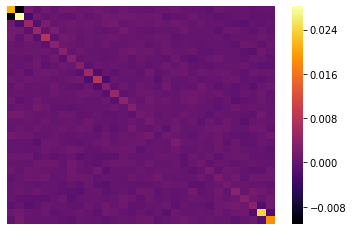

In [380]:
sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
plt.savefig('fake_cov_jla.png', dpi=200)
np.min(np.abs(decoded_fake[0, :]))

-0.01084098704 0.02815552265 0.00039265133851975654
-0.0110851 0.028207367 0.00040372016
-0.010904485 0.028100397 0.00038989805


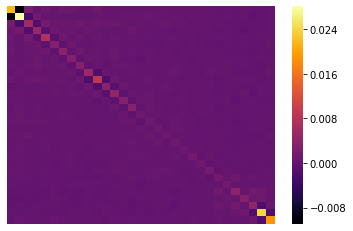

In [381]:
clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
sns.heatmap(pd.DataFrame(clean_img[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.savefig('fake_cov_clean_jla.png', dpi=200)
np.min(np.abs(clean_img[0, :]))

print(np.min(syscov), np.max(syscov), np.mean(syscov)) #checking non-negatives in the diagonal
print(np.min(decoded_fake[0,:]), np.max(decoded_fake[0,:]), np.mean(decoded_fake[0,:])) #checking non-negatives in the diagonal
print(np.min(clean_img[0,:]), np.max(clean_img[0,:]), np.mean(clean_img[0,:])) #checking non-negatives in the diagonal



In [382]:
np.savetxt("fake_binned_JLA_COVdecoded.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
np.savetxt("fake_binned_JLA_COVclean.dat", clean_img[0, :].reshape(31,31), delimiter= " ", header="#fake COV")

In [383]:
count = 0
new_cov =decoded_fake[0, :].reshape(31,31)

for i in range(len(new_cov)):
    for j in range(len(new_cov)):
        if np.iscomplex(new_cov[i,j]):
            print("COMPLEX")
        if new_cov[i,j] != new_cov[j,i]:
            print(i,j, end=' ')
            print(new_cov[i,j], new_cov[j,i]) 
            count+=1
            new_cov[j,i] = new_cov[i, j]

count

0 1 -0.0110851 -0.010592309
0 2 0.0016560534 0.0010858603
0 3 -0.0002587979 0.0014313353
0 4 0.0011788306 0.001428812
0 5 8.728492e-05 0.0004865802
0 6 0.0011251646 0.0006271244
0 7 0.0010814134 0.000112447655
0 8 0.0005142195 0.00039111252
0 9 0.00069608376 -3.6019366e-05
0 10 0.0013278197 0.0008501479
0 11 0.00071348564 -3.819412e-05
0 12 4.7232897e-05 7.37025e-05
0 13 0.000965457 0.0009190812
0 14 0.00025942386 -0.00017389562
0 15 0.00020202296 0.0014752211
0 16 -4.45412e-05 0.00030825174
0 17 0.00046438852 -4.0599494e-05
0 18 0.00047004456 0.001472325
0 19 0.0007596887 0.00019641215
0 20 0.0001752227 -4.574866e-05
0 21 0.00016381138 0.00093741465
0 22 -0.00018184772 0.0002753199
0 23 -0.0005590322 0.00075808866
0 24 0.00067955395 -0.00048417714
0 25 -2.8149341e-05 1.4263438e-05
0 26 -1.2026925e-05 0.00013815926
0 27 0.00017744725 0.00033099568
0 28 -0.00020877717 -0.00071346003
0 29 -4.02414e-05 0.0010197595
0 30 0.00016378507 -0.0004495258
1 2 -0.002376715 -0.0021804222
1 3 0.0011

15 22 5.9689046e-06 0.00026606536
15 23 -0.00053675944 0.0005949339
15 24 0.00031034078 0.00028381863
15 25 8.950941e-05 -0.00026904745
15 26 0.00014505722 0.0010297757
15 27 -0.00029553263 -0.00043409574
15 28 -0.00035443317 -0.00031271778
15 29 0.0012895239 0.0003500632
15 30 0.0002725902 0.0005863933
16 17 0.0003825113 -5.0019124e-05
16 18 0.00041614 0.0013656896
16 19 0.0009905489 -9.294919e-05
16 20 -7.0960086e-05 0.0002799963
16 21 0.0007161617 0.00010917056
16 22 -0.0006105273 0.0010404172
16 23 0.00062498753 0.00024663692
16 24 -0.00022436149 0.00056451396
16 25 0.00094647845 -0.00016854913
16 26 0.00023772701 0.00074326864
16 27 -0.0008365732 0.0007285236
16 28 0.00027763098 0.00031654467
16 29 0.00069651566 -0.0002857801
16 30 0.00037279597 0.0009996794
17 18 -0.00050998956 -0.00031142047
17 19 0.0011112082 0.00041664345
17 20 -2.1054177e-05 0.0002763002
17 21 -3.2480457e-05 0.00054634875
17 22 0.00036239176 0.00015187776
17 23 0.00077354844 0.00054102496
17 24 0.0010715339 0

465

In [384]:
np.savetxt("fake_binned_JLA_COVdecodedsim.dat", new_cov, delimiter= " ", header="#fake COV")

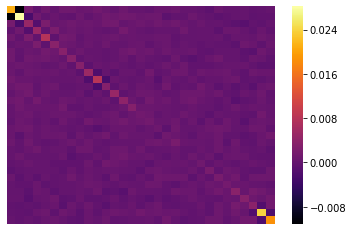

In [385]:
sns.heatmap(pd.DataFrame(new_cov), fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [386]:
fake_data = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)


np.savetxt("fake_binned_JLA.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu")
fake_data


array([[1.0000000000000000e-02, 3.5170333862304688e+01],
       [5.3000000000000005e-02, 3.7723030090332031e+01],
       [9.6000000000000002e-02, 3.9071662902832031e+01],
       [1.3900000000000001e-01, 3.9477718353271484e+01],
       [1.8200000000000002e-01, 3.9883781433105469e+01],
       [2.2500000000000003e-01, 4.0289199829101562e+01],
       [2.6800000000000002e-01, 4.0694015502929688e+01],
       [3.1100000000000005e-01, 4.1098834991455078e+01],
       [3.5400000000000004e-01, 4.1503646850585938e+01],
       [3.9700000000000002e-01, 4.1908470153808594e+01],
       [4.4000000000000006e-01, 4.2284381866455078e+01],
       [4.8300000000000004e-01, 4.2454177856445312e+01],
       [5.2600000000000002e-01, 4.2578830718994141e+01],
       [5.6900000000000006e-01, 4.2703475952148438e+01],
       [6.1200000000000010e-01, 4.2828125000000000e+01],
       [6.5500000000000003e-01, 4.2952877044677734e+01],
       [6.9800000000000006e-01, 4.3077930450439453e+01],
       [7.4100000000000010e-01,

In [387]:
errors = np.sqrt(np.abs(np.diagonal(syscov)))
fakeerrors = np.sqrt(np.abs(np.diagonal(clean_img.reshape(31,31))))

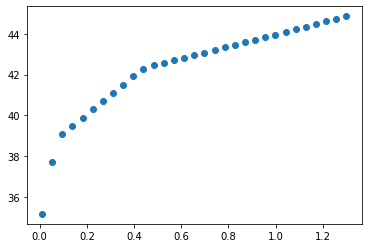

In [388]:
plt.scatter(ranz, pred_random)

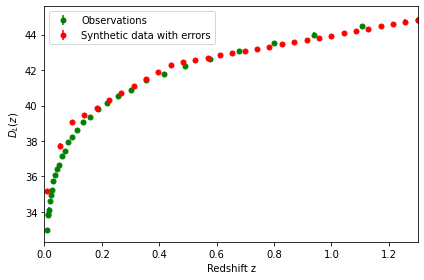

In [389]:
plt.errorbar(z, dl, yerr=errors, fmt='g.', markersize=10, label='Observations')
plt.errorbar(ranz, pred_random, 
             yerr=fakeerrors, fmt='r.', markersize=10., label='Synthetic data with errors')

# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
plt.xlim(0, np.max(z))
plt.tight_layout()
plt.legend()
plt.savefig('fake_vs_binned_jla.png', dpi=200)

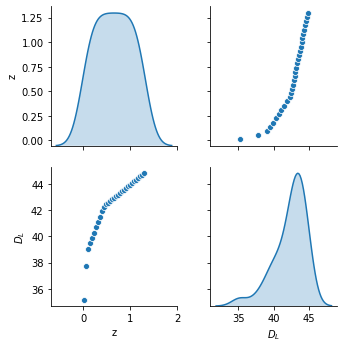

In [390]:
fake_datadf = pd.DataFrame(fake_data, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf, diag_kind="kde")
plt.savefig('fake_binned_jla.png')